In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import TimeStep
from tf_agents.policies import policy_saver

2024-01-13 00:13:40.431317: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import error


In [3]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-01-13 00:13:41.971091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:41.974402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:41.974587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [6]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  6000000,  # @param {type:"integer"}
"batch_size" :  256, # @param {type:"integer"}
"learning_rate" :  1e-5,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.03,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
#"conv_layer_params" : [(128,4,2), (256,4,2), (512,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : False,
"new_reward_function" : 1,
"step_size" : 4,
"random_init" : 0,
"n_agents" : 3,
"pred_session_name" : 'rand_walk_interpol_3_uav',
"mem_length" : 4, 
}

for key,val in all_params.items():
    exec(key + '=val')

In [7]:
# Setup environment 
train_env = RLEnv(model_path=pred_session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function, random_init=random_init,
                        n_uavs = n_agents, mem_length = mem_length)
eval_env = RLEnv(model_path=pred_session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function, random_init=random_init,
                        n_uavs = n_agents, mem_length = mem_length)

train_env.reset()
eval_env.reset()

There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loc

2024-01-13 00:13:45.366357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:45.366606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:45.366766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
[None, 48, 48, 32]
[None, 96, 96, 16]
(None, 96, 96, 1)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
(None, 96, 96, 1)
INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2024-01-13 00:13:48.669748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:48.669941: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-01-13 00:13:48.670029: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-01-13 00:13:48.670385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:48.670563: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2024-01-13 00:13:49.199490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:49.199686: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-01-13 00:13:49.199769: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-01-13 00:13:49.200011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:49.200174: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2024-01-13 00:13:51.872548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:51.872741: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-01-13 00:13:51.872820: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-01-13 00:13:51.873001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:51.873179: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2024-01-13 00:13:52.172071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:52.172275: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-01-13 00:13:52.172351: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-01-13 00:13:52.172657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:52.172840: I tensorflow/compiler/xla/stream_executor/

BoundedArraySpec(shape=(24, 24, 16), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)
There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
[None, 48, 48, 32]
[None, 96, 96, 16]
(None, 96, 96, 1)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 6

2024-01-13 00:13:58.962921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:58.963117: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-01-13 00:13:58.963173: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-01-13 00:13:58.963453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:58.963624: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2024-01-13 00:13:59.380811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:59.381016: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-01-13 00:13:59.381085: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-01-13 00:13:59.381267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:13:59.381434: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2024-01-13 00:14:01.911292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:14:01.911484: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-01-13 00:14:01.911545: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-01-13 00:14:01.911811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:14:01.911983: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2024-01-13 00:14:02.176958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:14:02.177167: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-01-13 00:14:02.177254: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-01-13 00:14:02.177423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 00:14:02.177591: I tensorflow/compiler/xla/stream_executor/

BoundedArraySpec(shape=(24, 24, 16), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


2024-01-13 00:14:02.975546: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2024-01-13 00:14:02.975632: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2024-01-13 00:14:06.927676: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


[TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.0000000

In [8]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2024-01-13--00:15:17'

In [9]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [10]:
# Convert to TF environment
train_py_env = train_env
eval_py_env = eval_env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [12]:

def main():
    eval_py_env.ee.policy = "random"
    eval_py_env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_steps = train_py_env.reset()
        reward_in_episode = 0
        while not time_steps[0].is_last():
            time_steps = eval_py_env.step(action=[1 for _ in time_steps])
            reward_in_episode += time_steps[0].reward
        all_rewards.append(reward_in_episode)
        final_errors.append(eval_py_env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    eval_py_env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()


UnboundLocalError: local variable 'rewards' referenced before assignment

In [ ]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [ ]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

2023-07-21 14:24:33.247534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-07-21 14:24:33.392051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [ ]:
# # Define eval function
# def compute_avg_return(environment, py_environment, policy, num_episodes=10):

#   total_return = 0.0
#   episode_errors = []

#   for i in range(num_episodes):

#     time_step = environment.reset()
#     episode_return = 0.0
    

#     while not time_step.is_last():
#       action_step = policy.action(time_step)
#       time_step = environment.step(action_step.action)
#       episode_return += time_step.reward
#     total_return += episode_return
#     episode_errors.append(py_environment.current_error)

#   avg_return = total_return / num_episodes
#   return avg_return.numpy()[0], np.mean(episode_errors), episode_errors

# # New eval function
# # Define eval function
def compute_avg_return(environment, policy, n_agents, num_episodes, batched = True):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):
    # Note that there will be multiple timestep objects for multiple n_agents
    time_steps = environment.reset()
    episode_return = 0.0
    

    while not time_steps[0].is_last():
      action_steps = []
      for agent_idx in range(n_agents):
        # Create a timestep with TF values
        

        if batched:
          discount = tf.constant([time_steps[agent_idx].discount])
          observation = tf.constant([time_steps[agent_idx].observation])
          reward = tf.constant([time_steps[agent_idx].reward])
          step_type = tf.constant([time_steps[agent_idx].step_type])
        else:
          observation = tf.constant(time_steps[agent_idx].observation)
          discount = tf.constant(time_steps[agent_idx].discount)
          reward = tf.constant(time_steps[agent_idx].reward)
          step_type = tf.constant(time_steps[agent_idx].step_type)
        tf_ts = TimeStep( step_type, reward, discount, observation)

        # Get action
        action_step = policy.action(tf_ts)
        action_steps.append(action_step)

      # Step the environment
      time_steps = environment.step([action_step.action for action_step in action_steps])
      
      # Get reward
      episode_return += time_steps[0].reward
      
    total_return += episode_return
    episode_errors.append(environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return, np.mean(episode_errors), episode_errors

In [ ]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error, errors = compute_avg_return(eval_py_env, random_policy, n_agents, num_episodes=1, batched = False)

print((rand_reward, rand_pred_error))


(22.911224365234375, 17.088775268744715)


In [ ]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observers = []
for _ in range(n_agents):
    rb_observer_i = reverb_utils.ReverbAddTrajectoryObserver(
        replay_buffer.py_client,
        table_name,     
        sequence_length=n_step_update+1)
    rb_observers.append(rb_observer_i)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpp7o8i1be.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpp7o8i1be
[reverb/cc/platform/default/server.cc:71] Started replay server on port 46007


In [ ]:
custom_py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    rb_observers,
    n_agents=n_agents,
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())

Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps


([TimeStep(
  {'discount': array(1., dtype=float32),
   'observation': array([[[ 0.65780115,  0.15828083,  0.        , ...,  0.15828083,
            0.        ,  0.        ],
          [ 0.8077966 ,  0.16567795,  0.        , ...,  0.16567795,
            0.        ,  0.        ],
          [ 0.80996364,  0.14822096,  0.        , ...,  0.14822096,
            0.        ,  0.        ],
          ...,
          [ 0.74772054,  0.16392422,  0.        , ...,  0.16392422,
            0.        ,  0.        ],
          [ 0.7443396 ,  0.15046212,  0.        , ...,  0.15046212,
            0.        ,  0.        ],
          [ 0.40067652,  0.19498026,  0.        , ...,  0.19498026,
            0.        ,  0.        ]],
  
         [[ 0.76827455,  0.14304356,  0.        , ...,  0.14304356,
            0.        ,  0.        ],
          [ 0.7920449 ,  0.13266316,  0.        , ...,  0.13266316,
            0.        ,  0.        ],
          [ 0.7528796 ,  0.12983808,  0.        , ...,  0.129838

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy, n_agents, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()





In [ ]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    rb_observers,
    n_agents=n_agents,
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [ ]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
best_reward = np.inf
losses = []
collect_rewards = []

In [ ]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*train_py_env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*train_py_env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

In [ ]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [ ]:
for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step[0].reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*train_py_env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*train_py_env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy, n_agents,num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {3}'.format(step, avg_return, avg_error, np.median(errors)))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)
      tf.compat.v2.summary.scalar(name="Median Error", data=np.median(errors), step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)
      #avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy,  n_agents,num_eval_episodes)
      #avg_return_collect, avg_error_collect, errors_collect = compute_avg_return(eval_py_env, agent.collect_policy,  n_agents,num_eval_episodes)
      print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {3}'.format(step, avg_return, avg_error, np.median(errors)))
      #print('step = {0}: Average Return 3 = {1}, Average Error 3 = {2}'.format(step, avg_return_collect, avg_error_collect))

step = 182000: loss = 3.581125497817993,  rew = 22.765563428401947
step = 183000: loss = 3.5790793895721436,  rew = 21.783258020877838
step = 184000: loss = 3.593332290649414,  rew = 22.981244325637817
step = 185000: loss = 3.5935935974121094,  rew = 25.951847434043884
step = 186000: loss = 3.6009700298309326,  rew = 23.14452826976776
step = 187000: loss = 3.5958328247070312,  rew = 23.130159080028534
step = 188000: loss = 3.570667028427124,  rew = 21.476389467716217
step = 189000: loss = 3.5849013328552246,  rew = 24.446769058704376
step = 190000: loss = 3.5724620819091797,  rew = 23.65065962076187
step = 191000: loss = 3.5897858142852783,  rew = 21.810829639434814
step = 192000: loss = 3.571636438369751,  rew = 23.537686467170715
step = 193000: loss = 3.584839344024658,  rew = 22.537383437156677
step = 194000: loss = 3.6088008880615234,  rew = 20.660309493541718
step = 195000: loss = 3.5901639461517334,  rew = 23.070403933525085
step = 196000: loss = 3.565814971923828,  rew = 25.0418

In [ ]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

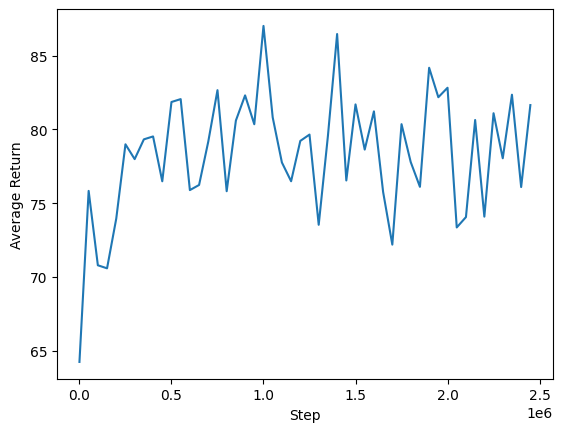

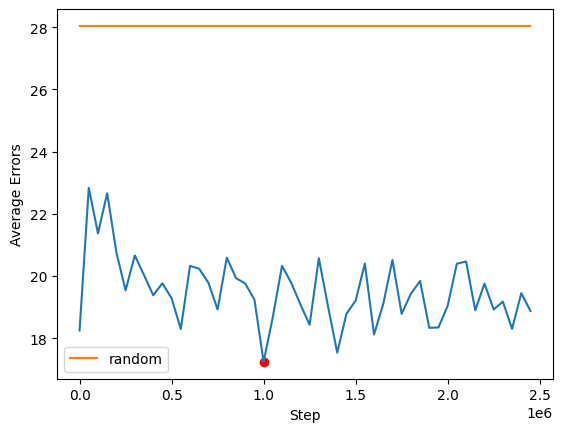

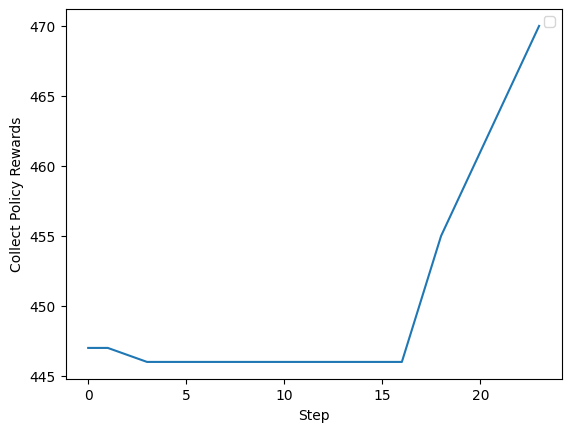

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Evaluate model again
avg_return, avg_error, all_errors  = compute_avg_return(eval_py_env, agent.policy, n_agents, 500, batched = True)
print(avg_return, avg_error)

25.802474497795107 14.197525512067584


In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error, all_errors  = compute_avg_return(eval_py_env, agent.policy, n_agents, 500, batched = True)
print(avg_return, avg_error)

25.669357946395873 14.340479884015574


In [ ]:
saved_policy = tf.saved_model.load(train_log_dir)
#saved_policy = tf.saved_model.load("./models/RL/2023-06-09--00:06:51")
avg_return, avg_error, all_errors = compute_avg_return(eval_py_env, saved_policy, n_agents, 500, batched = True)
print(avg_return, avg_error, np.median(all_errors))

25.71741012477875 14.294826448055886 12.842082088389558
